# Bernoulli HMM Example Notebook

Modified from https://github.com/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb

Changes: It uses pyprobml's dynamax library, and finds the permutation between inferrred and true latent state labels in a different way.


In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

#### Imports and Plotting Functions 

In [3]:
from functools import partial
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
from pprint import pprint

from dynamax.hidden_markov_model import BernoulliHMM

In [4]:
def find_permutation(z1, z2):
    K1 = z1.max() + 1
    K2 = z2.max() + 1

    perm = []
    for k1 in range(K1):
        indices = jnp.where(z1 == k1)[0]
        counts = jnp.bincount(z2[indices])
        perm.append(jnp.argmax(counts))

    return jnp.array(perm)

In [5]:
def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (10, 5)
    if is_latexify_enabled():
        figsize = None
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_posterior_states(Ez, states, perm):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (25, 5)
    if is_latexify_enabled():
        figsize = None
    plt.figure(figsize=figsize)
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State", linewidth=1)
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")

# Bernoulli HMM

### Let's create a true model

In [6]:
num_states = 5
emission_dim = 10
true_hmm = BernoulliHMM(num_states, emission_dim, 
                        emission_prior_concentration0=1.0, 
                        emission_prior_concentration1=1.0)

In [7]:
initial_probs = jnp.ones((num_states,)) / (num_states * 1.0)
transition_matrix = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states
true_params, _ = true_hmm.initialize(key=jr.PRNGKey(0), initial_probs=initial_probs, transition_matrix=transition_matrix)
pprint(true_params)

{'emissions': {'probs': DeviceArray([[0.08711605, 0.8859111 , 0.0553588 , 0.89266485, 0.6542777 ,
              0.36523718, 0.9005018 , 0.27574348, 0.72534186, 0.20504773],
             [0.35098976, 0.52732176, 0.5617866 , 0.77754116, 0.65733916,
              0.9501746 , 0.565591  , 0.9692118 , 0.8197006 , 0.48312208],
             [0.42105263, 0.7218931 , 0.6749209 , 0.00552619, 0.3317946 ,
              0.03885067, 0.09660687, 0.51793253, 0.4204833 , 0.12704149],
             [0.96767586, 0.91378534, 0.3094893 , 0.942032  , 0.73226786,
              0.7472734 , 0.81867903, 0.5877778 , 0.26151833, 0.905447  ],
             [0.11620105, 0.60571456, 0.7441712 , 0.19335696, 0.09847692,
              0.10839706, 0.54097974, 0.28973532, 0.9317195 , 0.31257284]],            dtype=float32)},
 'initial': {'probs': DeviceArray([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32)},
 'transitions': {'transition_matrix': DeviceArray([[0.91999996, 0.02      , 0.02      , 0.02      , 0.02      ],
           

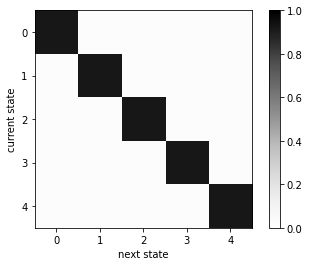

In [8]:
plot_transition_matrix(true_params["transitions"]["transition_matrix"])

In [9]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(true_params["emissions"]["probs"])

Emission probabilities (num states x num emission_dims (aka channels)):
[[0.08711605 0.8859111  0.0553588  0.89266485 0.6542777  0.36523718
  0.9005018  0.27574348 0.72534186 0.20504773]
 [0.35098976 0.52732176 0.5617866  0.77754116 0.65733916 0.9501746
  0.565591   0.9692118  0.8197006  0.48312208]
 [0.42105263 0.7218931  0.6749209  0.00552619 0.3317946  0.03885067
  0.09660687 0.51793253 0.4204833  0.12704149]
 [0.96767586 0.91378534 0.3094893  0.942032   0.73226786 0.7472734
  0.81867903 0.5877778  0.26151833 0.905447  ]
 [0.11620105 0.60571456 0.7441712  0.19335696 0.09847692 0.10839706
  0.54097974 0.28973532 0.9317195  0.31257284]]


### From the true model, we can sample synthetic data

In [10]:
rng = jr.PRNGKey(0)
num_timesteps = 500

true_states, emissions = true_hmm.sample(true_params, rng, num_timesteps)

### Let's view the synthetic data

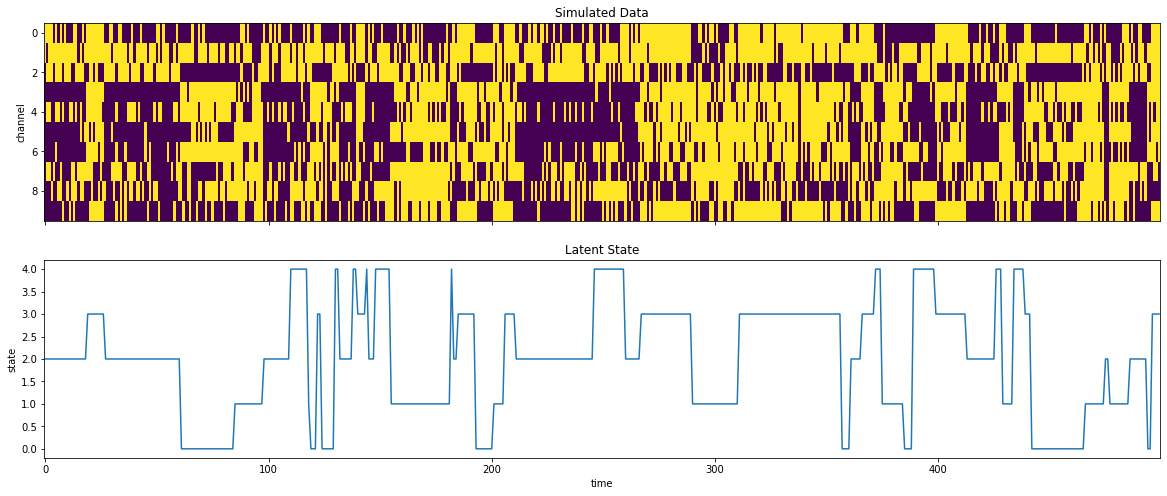

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(emissions.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("Simulated Data")
axs[1].plot(true_states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


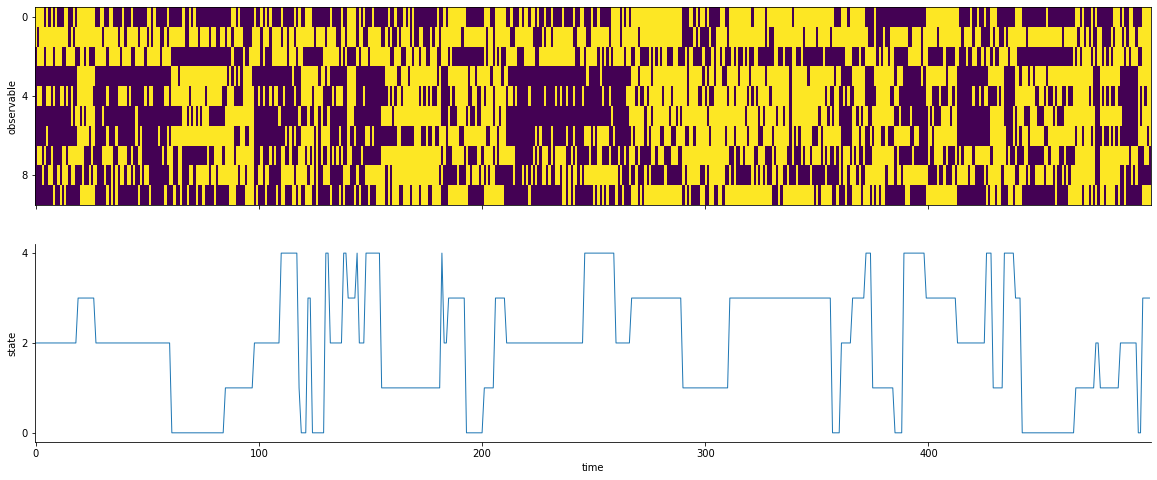

In [12]:
latexify(width_scale_factor=1, fig_height=2)
figsize = (20, 8)
if is_latexify_enabled():
    figsize = None
fig, axs = plt.subplots(2, 1, sharex=True, figsize=figsize)
axs[0].imshow(emissions.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("observable")
axs[0].set_yticks([0, 4, 8])
axs[1].plot(true_states, linewidth=1)
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
axs[1].set_yticks([0, 2, 4])
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
if is_latexify_enabled():
    plt.subplots_adjust(hspace=4)
savefig("bernoulli-hmm-data")
plt.show()

## Fit HMM using exact EM update

In [14]:
test_hmm = BernoulliHMM(num_states, emission_dim)
params, props = test_hmm.initialize(key=jr.PRNGKey(1))
params, lps = test_hmm.fit_em(params, props, emissions)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
num_iters = 20
test_params, lps = test_hmm.fit_em(test_params, test_props, emissions, num_iters=num_iters)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'log likelihood')

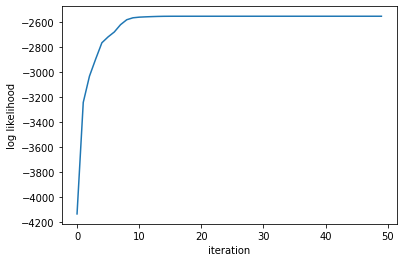

In [15]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


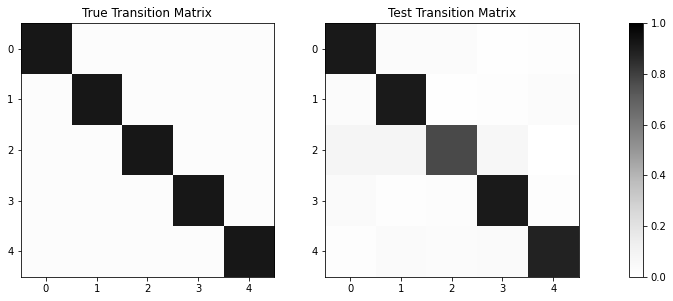

In [16]:
# Compare the transition matrices
compare_transition_matrix(true_params["transitions"]["transition_matrix"], params["transitions"]["transition_matrix"])

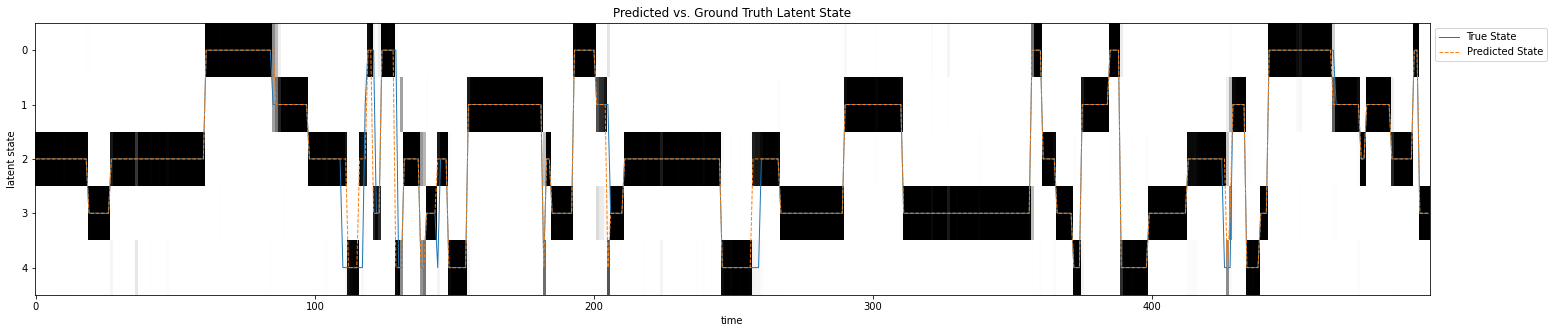

In [17]:
# Posterior distribution
posterior = test_hmm.smoother(params, emissions)
Ez = posterior.smoothed_probs
perm = find_permutation(true_states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez, true_states, perm)

# Fit Bernoulli Over Multiple Trials

In [18]:
rng = jr.PRNGKey(0)
num_trials = 5
keys = jr.split(rng, num_trials)
num_timesteps = 500

all_true_states, all_emissions = vmap(partial(true_hmm.sample, true_params, num_timesteps=num_timesteps))(keys)

In [19]:
# Now we have a batch dimension of size `num_trials`
print(all_true_states.shape)
print(all_emissions.shape)

(5, 500)
(5, 500, 10)


In [20]:
num_iters = 100
parms, props = test_hmm.initialize(key=jr.PRNGKey(2))
params, lps = test_hmm.fit_em(params, props, all_emissions, num_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

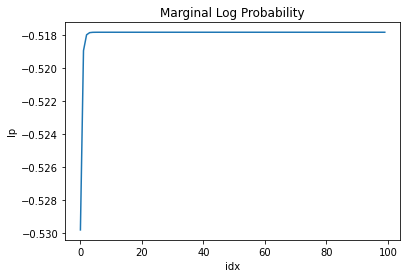

In [21]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(jnp.array(lps) / all_emissions.size)

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


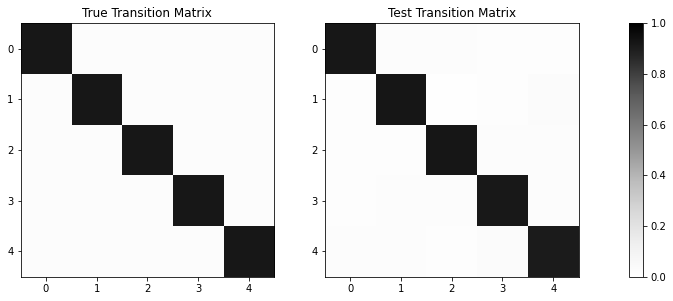

In [22]:
# Compare the transition matrices
compare_transition_matrix(true_params["transitions"]["transition_matrix"], params["transitions"]["transition_matrix"])

===== Trial: 0 =====
===== Trial: 1 =====
===== Trial: 2 =====


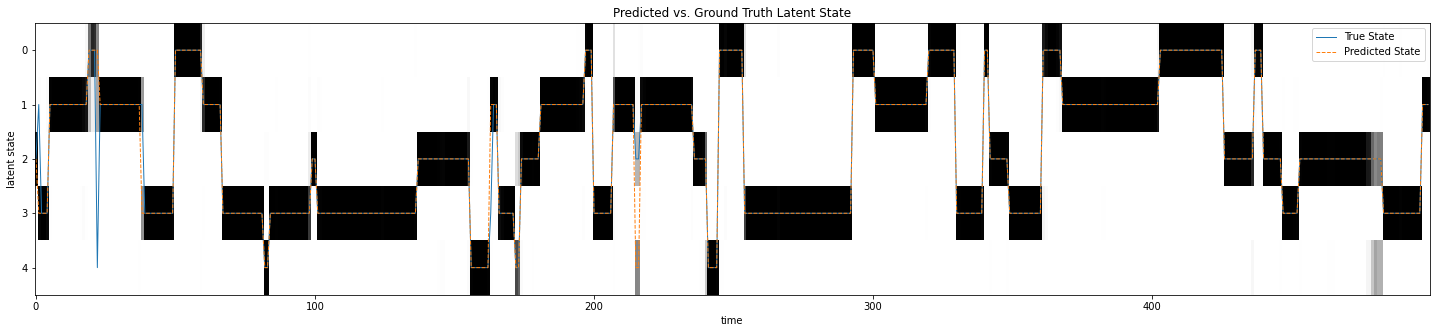

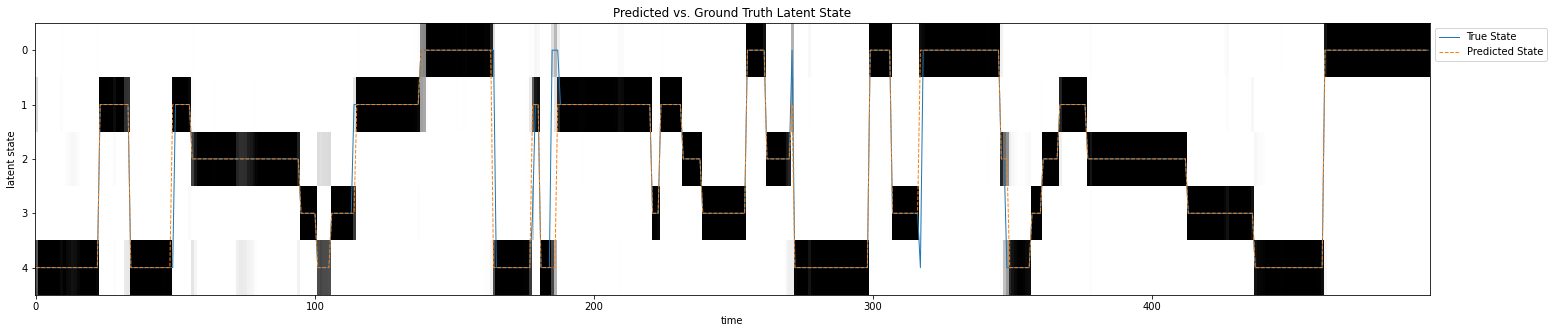

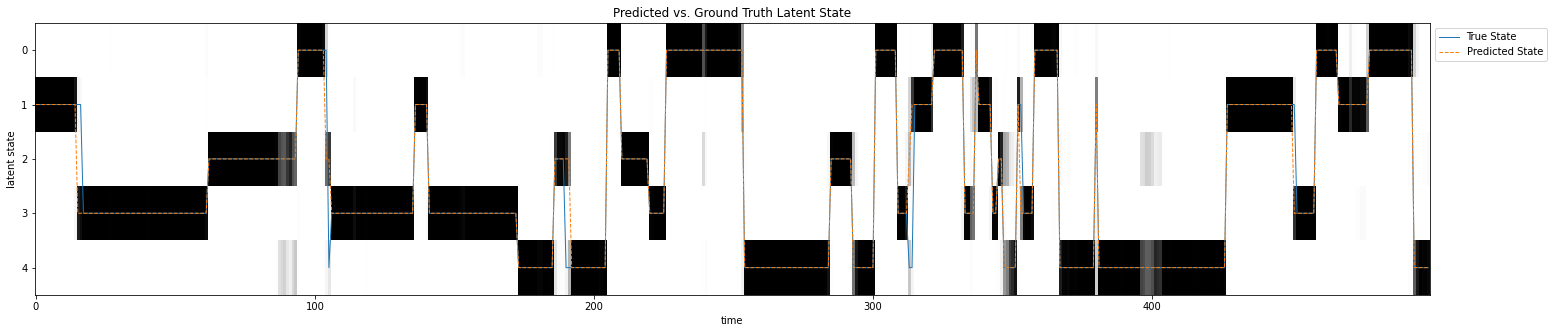

In [23]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    posterior = test_hmm.smoother(params, all_emissions[trial_idx])
    Ez = posterior.smoothed_probs
    states = all_true_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)